In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys
import gillespy2


In [13]:
# Model definition.
# .............................................................................
# In GillesPy2, a model to be simulated is expressed as an object having the
# parent class "Model".  Components of the model to be simulated, such as the
# reactions, molecular species, and the time span for simualtion, are all
# defined within the class definition.

class Tyson2StateOscillator(gillespy2.Model):
    """
    Here, as a test case, we run a simple two-state oscillator (Novak & Tyson
    2008) as an example of a stochastic reaction system.
    """
    def __init__(self, parameter_values=None):
        """
        """
        system_volume = 300 #system volume
        gillespy2.Model.__init__(self, name="tyson-2-state", volume=system_volume)
        self.timespan(np.linspace(0,100,101))

        # =============================================
        # Define model species, initial values, parameters, and volume
        # =============================================

        # Parameter values  for this biochemical system are given in
        # concentration units. However, stochastic systems must use population
        # values. For example, a concentration unit of 0.5mol/(L*s)
        # is multiplied by a volume unit, to get a population/s rate
        # constant. Thus, for our non-mass action reactions, we include the
        # parameter "vol" in order to convert population units to concentration
        # units. Volume here = 300.

        P   = gillespy2.Parameter(name='P', expression=2.0)
        kt  = gillespy2.Parameter(name='kt', expression=20.0)
        kd  = gillespy2.Parameter(name='kd', expression=1.0)
        a0  = gillespy2.Parameter(name='a0', expression=0.005)
        a1  = gillespy2.Parameter(name='a1', expression=0.05)
        a2  = gillespy2.Parameter(name='a2', expression=0.1)
        kdx = gillespy2.Parameter(name='kdx', expression=1.0)
        self.add_parameter([P, kt, kd, a0, a1, a2, kdx])

        # Species
        # Initial values of each species (concentration converted to pop.)
        X = gillespy2.Species(name='X', initial_value=int(0.65609071*system_volume))
        Y = gillespy2.Species(name='Y', initial_value=int(0.85088331*system_volume))
        self.add_species([X, Y])

        # =============================================
        # Define the reactions within the model
        # =============================================

        # creation of X:
        rxn1 = gillespy2.Reaction(name = 'X production',
                                  reactants = {},
                                  products = {X:1},
                                  propensity_function = 'vol*1/(1+(Y*Y/((vol*vol))))')

        # degradadation of X:
        rxn2 = gillespy2.Reaction(name = 'X degradation',
                                  reactants = {X:1},
                                  products = {},
                                  rate = kdx)

        # creation of Y:
        rxn3 = gillespy2.Reaction(name = 'Y production',
                                  reactants = {X:1},
                                  products = {X:1, Y:1},
                                  rate = kt)

        # degradation of Y:
        rxn4 = gillespy2.Reaction(name = 'Y degradation',
                                  reactants = {Y:1},
                                  products = {},
                                  rate = kd)

        # nonlinear Y term:
        rxn5 = gillespy2.Reaction(name = 'Y nonlin',
                                  reactants = {Y:1},
                                  products = {},
                                  propensity_function = 'Y/(a0 + a1*(Y/vol)+a2*Y*Y/(vol*vol))')

        self.add_reaction([rxn1,rxn2,rxn3,rxn4,rxn5])

        self.timespan(np.linspace(0,20,21))

In [14]:
# A simulation in GillesPy2 is performed by first instantiating the model
# to be simulated, and then invoking the "run" method on that object.
# The results of the simulation are the output of "run".

tyson_model = Tyson2StateOscillator()
%time results = tyson_model.run()

CPU times: user 12 ms, sys: 20 ms, total: 32 ms
Wall time: 2.89 s


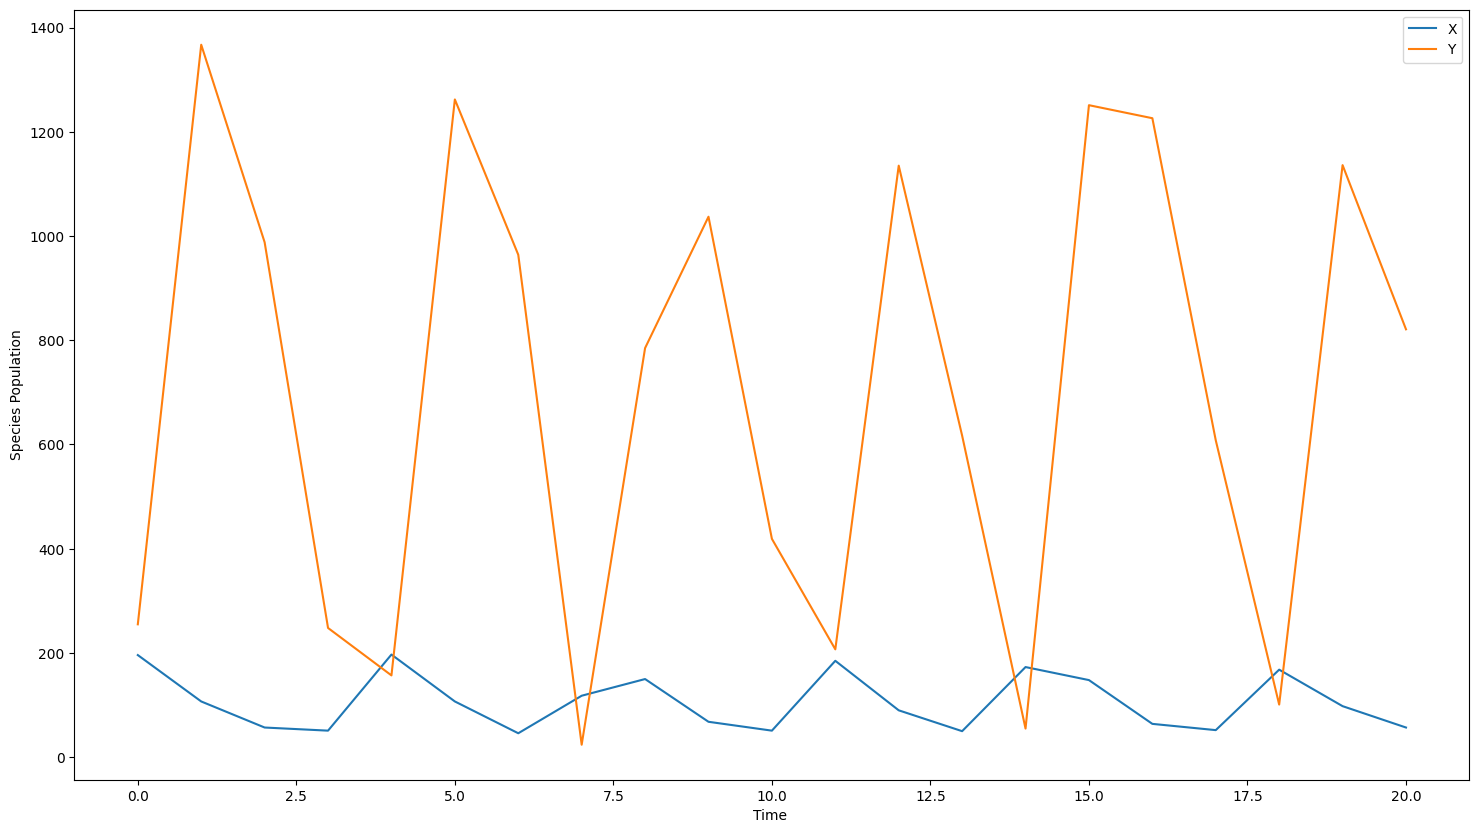

In [15]:
results.plot()

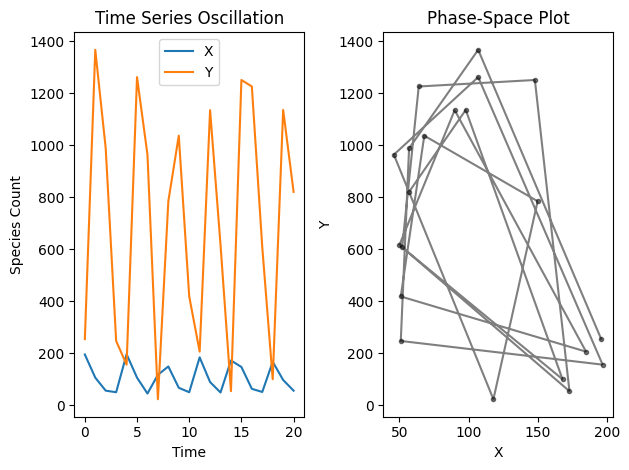

In [16]:
trajectories = results[0]
gs = gridspec.GridSpec(1,2)

ax0 = plt.subplot(gs[0,0])
ax0.plot(trajectories['time'], trajectories['X'], label='X')
ax0.plot(trajectories['time'], trajectories['Y'], label='Y')
ax0.legend()
ax0.set_xlabel('Time')
ax0.set_ylabel('Species Count')
ax0.set_title('Time Series Oscillation')

ax1 = plt.subplot(gs[0,1])
ax1.plot(trajectories['X'], trajectories['Y'], '.-k', alpha=0.5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Phase-Space Plot')

plt.tight_layout()